# Setting up BackendArray to Process OpenVisus Dataset into Xarray
1. 'xarray.open_dataset' takes input of url link to '.idx' dataset
2. Timesteps and resolution are optional, but can be passed here, or accessed later
3. Works for both 2-D and 3-D datasets

In [6]:
import xarray as xr
import numpy  as np
import pandas as pd


# !pip install OpenVisusNoGui
import OpenVisus as ov

# see https://xarray.pydata.org/en/stable/internals/how-to-add-new-backend.html


# ////////////////////////////////////////////////////////////
class OpenVisusBackendArray(xr.backends.common.BackendArray):
#     TODO: add num_refinements,quality
#     TODO: adding it for normalized coordinates 

    # constructor
    def __init__(self,db, shape, dtype, timesteps,resolution,ncomponents):
        self.db    = db
        self.shape = shape
        self.dtype = dtype
        self.ncomponents=ncomponents
        self.pdim=db.getPointDim()
        self.timesteps=timesteps
        self.resolution=resolution

    # _getKeyRange
    def _getKeyRange(self, value):
        A = value.start if isinstance(value, slice) else value    ; A = 0             if A is None else A
        B = value.stop  if isinstance(value, slice) else value + 1; B = np.max(self.shape) if B is None else B
        return (A,B)
    # __readSamples
    def _raw_indexing_method(self, key: tuple) -> np.typing.ArrayLike:
        print("_raw_indexing_method","key",key)
        if self.pdim==2:
            # getting selection from the data
            t1,t2=self._getKeyRange(key[0])
            y1,y2=self._getKeyRange(key[1])
            x1,x2=self._getKeyRange(key[2])
            c1,c2=self._getKeyRange(key[3])
            
            if isinstance(self.resolution,int):
                res=self.resolution                
            else:
                res,res1=self._getKeyRange(key[-1])

                if res==0:
                    
                    res= self.db.getMaxResolution()
                    print('Using Max Resolution: ',res) 
            if isinstance(self.timesteps,int): 
                data=self.db.read(time=self.timesteps,max_resolution=res, logic_box=[(x1,y1),(x2,y2)])
            else:
                
                if isinstance(t1,int) and isinstance(res,int):

                    data=self.db.read(time=t1,max_resolution=res,logic_box=[(x1,y1),(x2,y2)])
                else:
                    data=self.db.read(logic_box=[(x1,y1),(x2,y2)],max_resolution=self.db.getMaxResolution())   
                
        elif self.pdim==3:
            
            t1,t2=self._getKeyRange(key[0])
            z1,z2=self._getKeyRange(key[1])
            y1,y2=self._getKeyRange(key[2])
            x1,x2=self._getKeyRange(key[3])            
            
            if isinstance(self.resolution,int):
                res=self.resolution
            else:
                res,res1=self._getKeyRange(key[-1])

                if res==0:
                    self.shape.pop()
                    res= self.db.getMaxResolution()
                    print('Using Max Resolution: ',res)   
            if isinstance(self.timesteps,int):
                data=self.db.read(time=self.timesteps,max_resolution=res, logic_box=[(x1,y1,z1),(x2,y2,z2)])
            elif len(self.timesteps)==1:
                data=self.db.read(max_resolution=res,logic_box=[(x1,y1,z1),(x2,y2,z2)])
 
            else:
                
                if isinstance(t1, int) and isinstance(res,int):

                    data=self.db.read(time=t1, max_resolution=res,logic_box=[(x1,y1,z1),(x2,y2,z2)])
                else:

                    data=self.db.read(logic_box=[(x1,y1,z1),(x2,y2,z2)])
                    
        else:
            raise Exception("dimension error")

#         # last key element is the channel
        print(data.shape)
        
        if self.ncomponents>1 :
             #Y,X,Channel
            if self.pdim==2:
                data=data[:,:,c1:c2]


            # Z,Y,X,Channel
            elif self.pdim==3:
                c1,c2=self._getKeyRange(key[4])

                data=data[:,:,:,c1:c2]

            else:
                raise Exception("problem")
        
        return np.array([data]) 
    # __getitem__
    def __getitem__(self, key: xr.core.indexing.ExplicitIndexer) -> np.typing.ArrayLike:
        return xr.core.indexing.explicit_indexing_adapter(key,self.shape,
                                                          xr.core.indexing.IndexingSupport.BASIC,
                                                          self._raw_indexing_method)

In [7]:

class OpenVisusBackendEntrypoint(xr.backends.common.BackendEntrypoint):

    open_dataset_parameters = ["filename_or_obj", "drop_variables", "resolution", "timesteps"]
    
    # open_dataset
    def open_dataset(self,filename_or_obj,*, resolution=None, timesteps=None,drop_variables=None):

        self.resolution=resolution

        data_vars={}

        db=ov.LoadDataset(filename_or_obj)
#         print(db.getMaxResolution())
        self.timesteps=timesteps
        dim=db.getPointDim()
        dims=db.getLogicSize()
        if self.timesteps==None: 
            self.timesteps=[int(it) for it in db.getTimesteps().asVector()]
            
        # convert OpenVisus fields into xarray variables
        for fieldname in db.getFields():
            field=db.getField(fieldname)
            
            ncomponents=field.dtype.ncomponents()
            atomic_dtype=field.dtype.get(0)

            # note: OpenVisus can have dtype uint8[3],numpy cannot
            # for this reason for example
            # 1024x768     uint8       becomes (768,1024)      np.uint8    (NOTE I don't have to add anything to the shape)
            # 1024x768     uint8[3]    becomes (768,1024,3)    np.uint8    (NOTE I am adding a '3' to the shape)
            # 100x200x300  float64     becomes (300,200,100)   np.float64  (NOTE I don't have to add anything to the shape)
            # 100x200x300  float64[2]  becomes (300,200,100,2) np.float64  (NOTE I am adding a '2' to the shape)

            dtype=self.toNumPyDType(atomic_dtype) 

            if dim==2:
                labels=["y", "x"]
            elif dim==3:
                labels=["z", "y", "x"]
            else:
                raise Exception("assigning labels error")
                
            shape=list(reversed(dims))
            
            if ncomponents>1:
                labels.append("channel")
                shape.append(ncomponents)
            labels.insert(0,"time")
            labels.append("resolution")
            if isinstance(self.resolution,int):
                    
                shape.append(self.resolution+1)  
            else:
                shape.append(db.getMaxResolution()+1)
            if isinstance(self.timesteps, int):
                shape.insert(0,self.timesteps+1)  
            else:
                shape.insert(0,len(self.timesteps))



            data_vars[fieldname]=xr.Variable(
                labels, 
                xr.core.indexing.LazilyIndexedArray(OpenVisusBackendArray(db=db, shape=shape,dtype=dtype,
                                                                          timesteps=self.timesteps,
                                                                          resolution=self.resolution,
                                                                          ncomponents=ncomponents)), 
                attrs={} # no attributes
            )

            print("Adding field ",fieldname,"shape ",shape,"dtype ",dtype,"labels ",labels,"timesteps ",self.timesteps,
                 "Max Resolution ", db.getMaxResolution())
        ds = xr.Dataset(data_vars=data_vars)

        ds.set_close(self.close_method)
        
        return ds
    
    # toNumPyDType (always pass the atomic OpenVisus type i.e. uint8[8] should not be accepted)
    def toNumPyDType(self,atomic_dtype):
        """
        convert an Openvisus dtype to numpy dtype
        """

        # dtype  (<: little-endian, >: big-endian, |: not-relevant) ; integer providing the number of bytes  ; i (integer) u (unsigned integer) f (floating point)
        return np.dtype("".join([
            "|" if atomic_dtype.getBitSize()==8 else "<",
            "f" if atomic_dtype.isDecimal() else ("u" if atomic_dtype.isUnsigned() else "i"),
            str(int(atomic_dtype.getBitSize()/8))
        ])) 

    # close_method
    def close_method(self):
        print("nothing to do here")
    
    # guess_can_open
    def guess_can_open(self, filename_or_obj):
        print("guess_can_open",filename_or_obj)

        # todo: extend to S3 datasets
        if "mod_visus" in filename_or_obj:
            return True
         
        # local files
        try:
            _, ext = os.path.splitext(filename_or_obj)
        except TypeError:
            return False
        return ext.lower()==".idx"



In [8]:
import matplotlib.pyplot as plt
def ShowData(data):
    fig = plt.figure(figsize = (70,20))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(data, origin='lower')
    plt.show()

def Show3D(data):
    fig = plt.figure(figsize = (70,20))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.contourf(data[1],data[0], origin='lower')
    plt.show()


In [11]:
# data = np.random.randn(2, 3)

# # create coords
# rows = [1,2]
# cols = [1,2,3]

# # put data into a dataset
# ds = xr.Dataset(
#     data_vars=dict(
#         variable=(["x", "y","z"], data)
#     ),
#     coords=dict(
#         lon=(["x"], rows),
#         lat=(["y"], cols),
#         tim=([])
#     ),
#     attrs=dict(description="coords with vectors"),
# )
# ds

Adding field  data shape  [12, 43200, 86400, 3, 34] dtype  uint8 labels  ['time', 'y', 'x', 'channel', 'resolution'] timesteps  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] Max Resolution  33
_raw_indexing_method key (11, slice(25000, 33000, 1), slice(20000, 27000, 1), slice(None, None, None), 20)
(62, 109, 3)


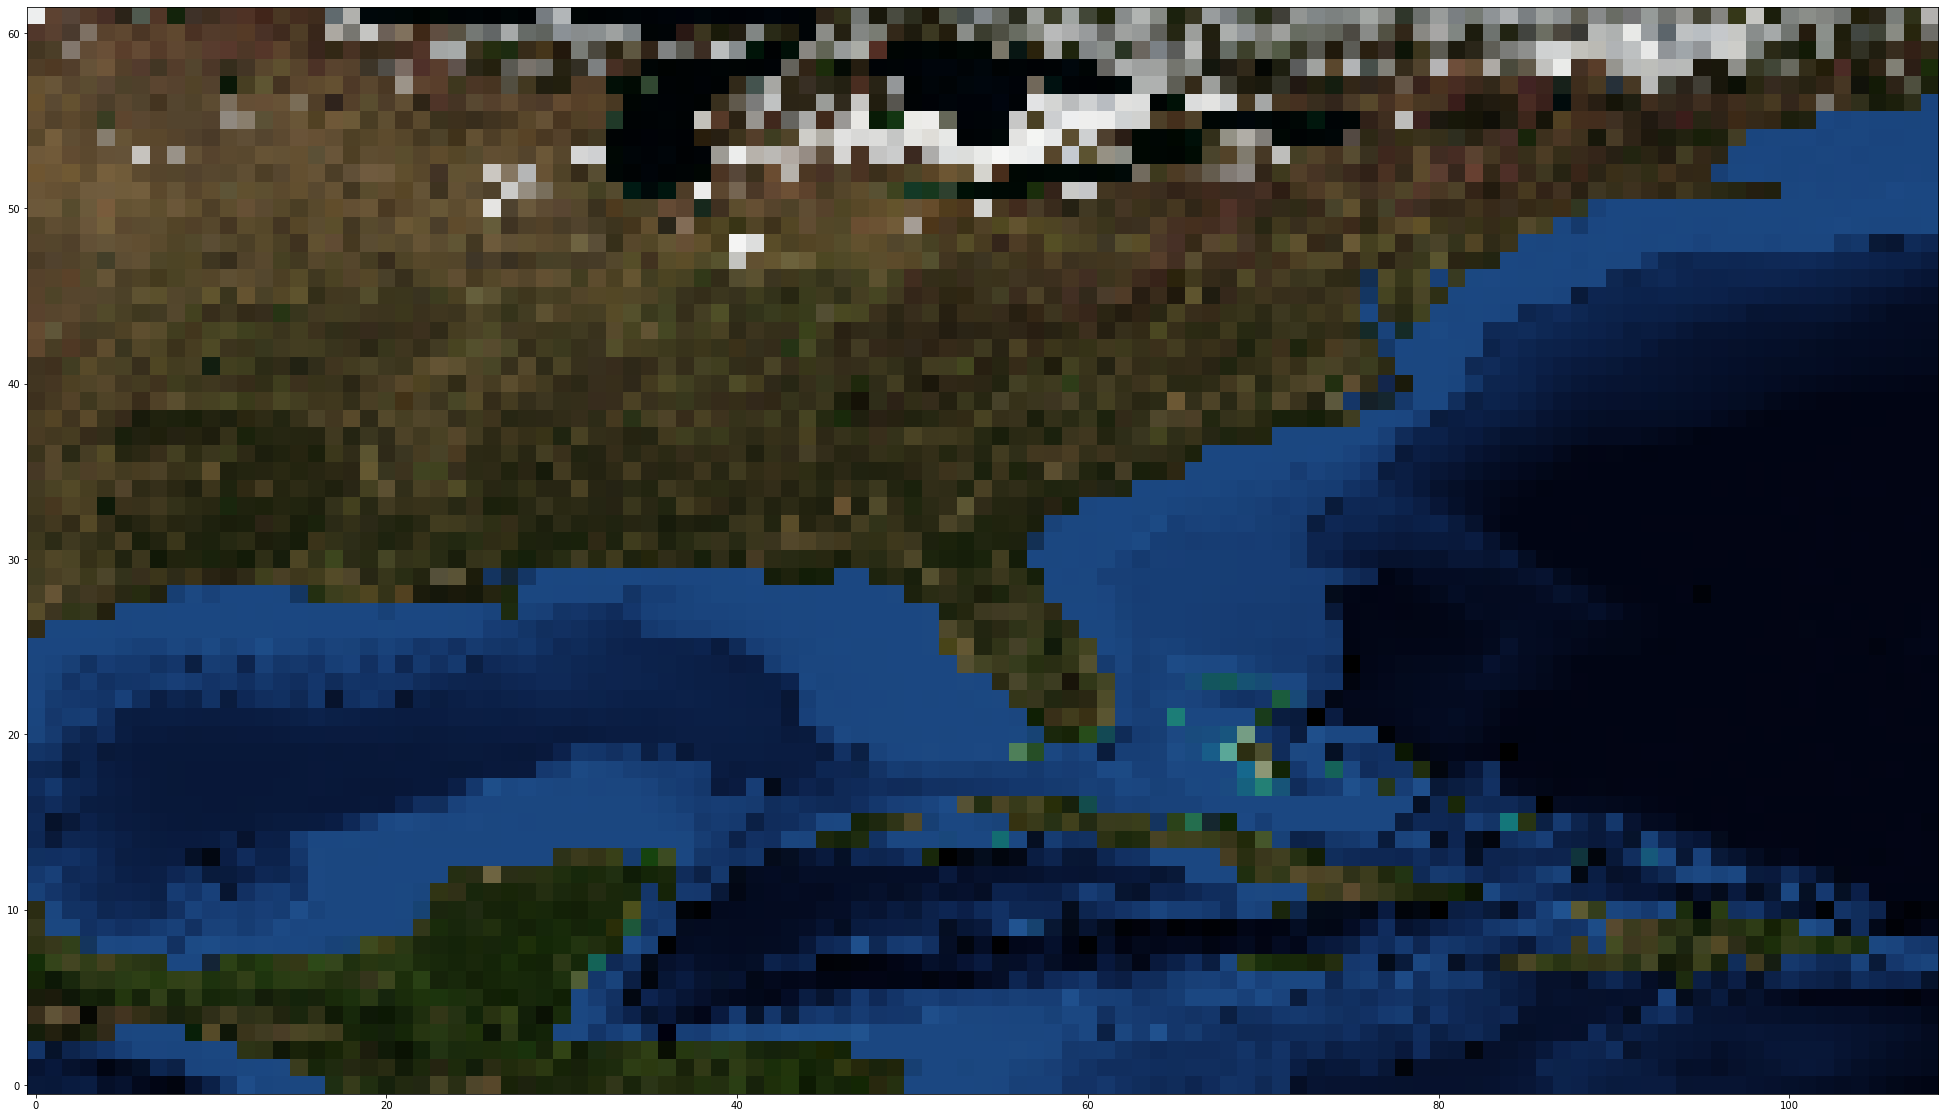

CPU times: user 385 ms, sys: 143 ms, total: 528 ms
Wall time: 254 ms


In [12]:
%%time
ds = xr.open_dataset("http://atlantis.sci.utah.edu/mod_visus?dataset=BlueMarble",engine=OpenVisusBackendEntrypoint)
# print(ds.data[10,25000:33000,20000:27000].shape)

data=ds.data[11,25000:33000,20000:27000,:,20].values

ShowData(data[0])
# print(data)


Adding field  C02 shape  [1, 857, 13917, 10485, 39] dtype  uint8 labels  ['time', 'z', 'y', 'x', 'resolution'] timesteps  [0] Max Resolution  38
_raw_indexing_method key (0, slice(800, 851, 1), slice(0, 13917, 1), slice(0, 10485, 1), 24)
(2, 435, 656)


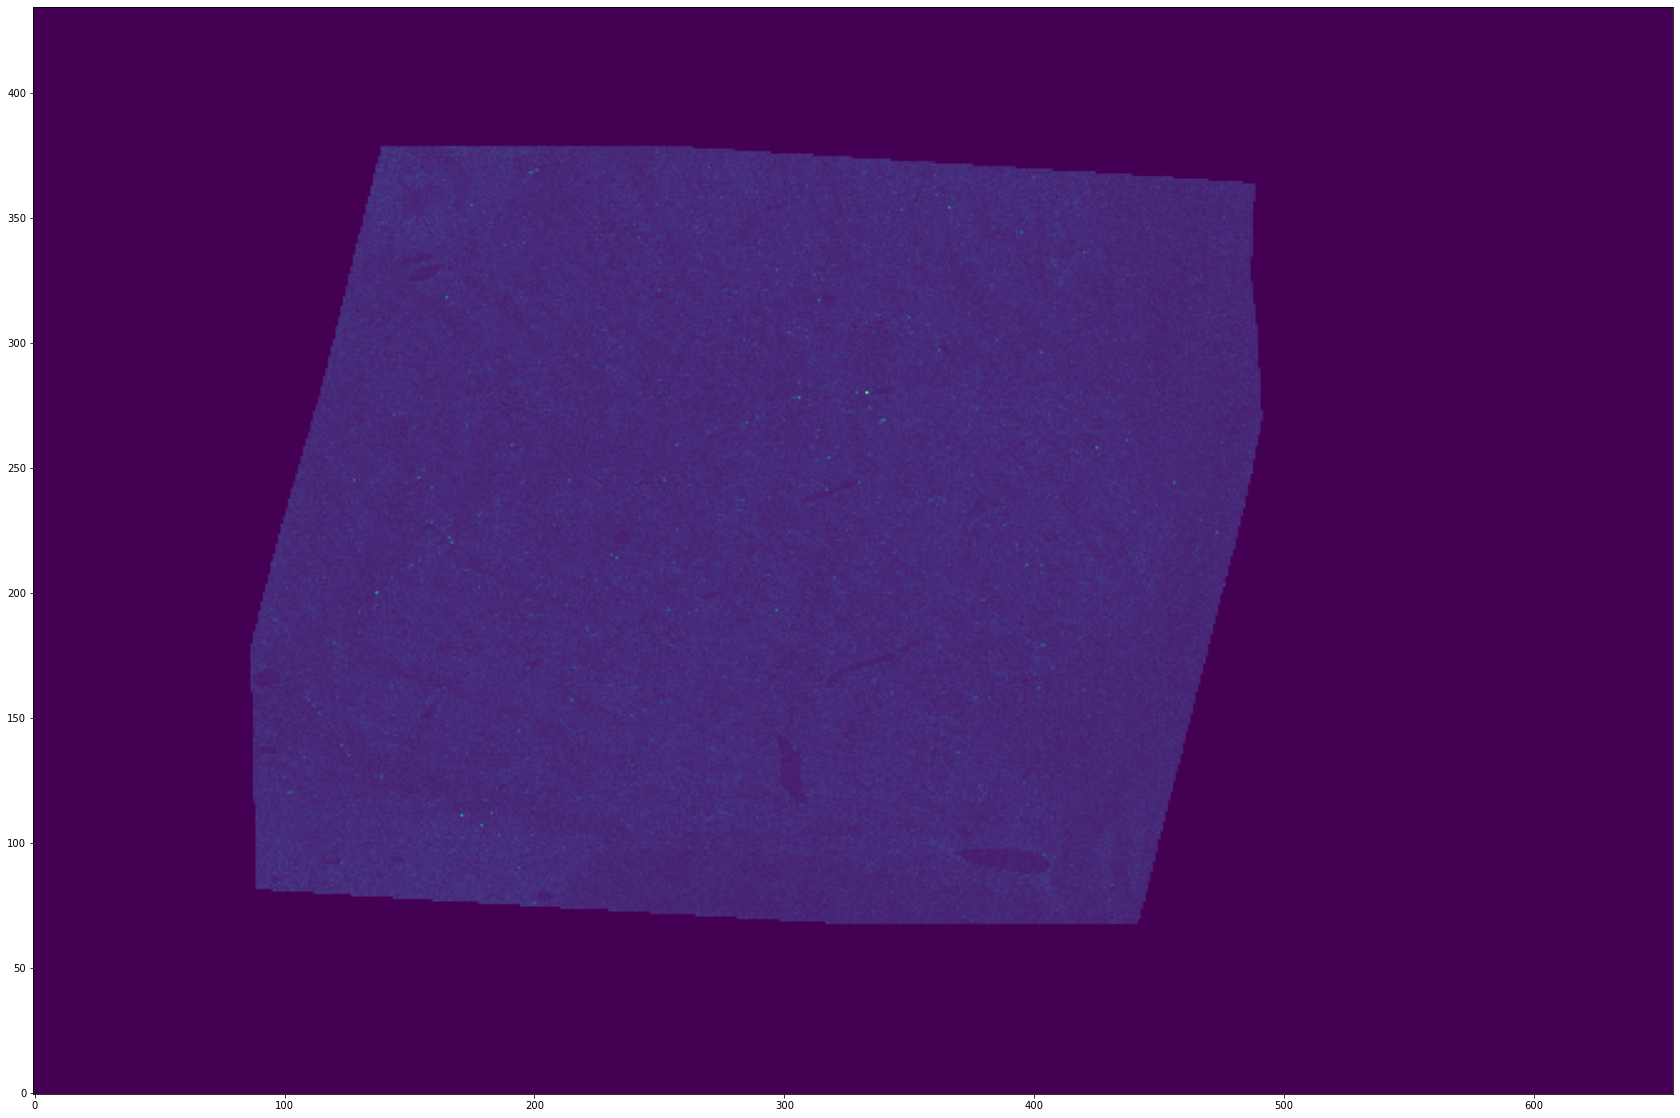

In [54]:
# /mod_visus?action=readdataset&dataset=arc

ds = xr.open_dataset("http://atlantis.sci.utah.edu/mod_visus?action=readdataset&dataset=arc",engine=OpenVisusBackendEntrypoint)

data=ds.C02[0,800:851,:13917,:10485,24].values



ShowData(data[0,0,:,:])

### Multi-resolution Demo

### Note that the passed values to access the data are in order of 'time',  'y','x','resolution', (resolution is optional)

## Example 1 for Climate dataset Using Xarray backend
### Note that the passed values to access the data are in order of 'time', 'resolution', 'y','x', 'channel' (channel is optional)

Adding field  data shape  [12, 43200, 86400, 3, 34] dtype  uint8 labels  ['time', 'y', 'x', 'channel', 'resolution'] timesteps  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] Max Resolution  33
_raw_indexing_method key (10, slice(25000, 33000, 1), slice(20000, 27000, 1), slice(None, None, None), slice(None, None, None))
Using Max Resolution:  33
(8000, 7000, 3)


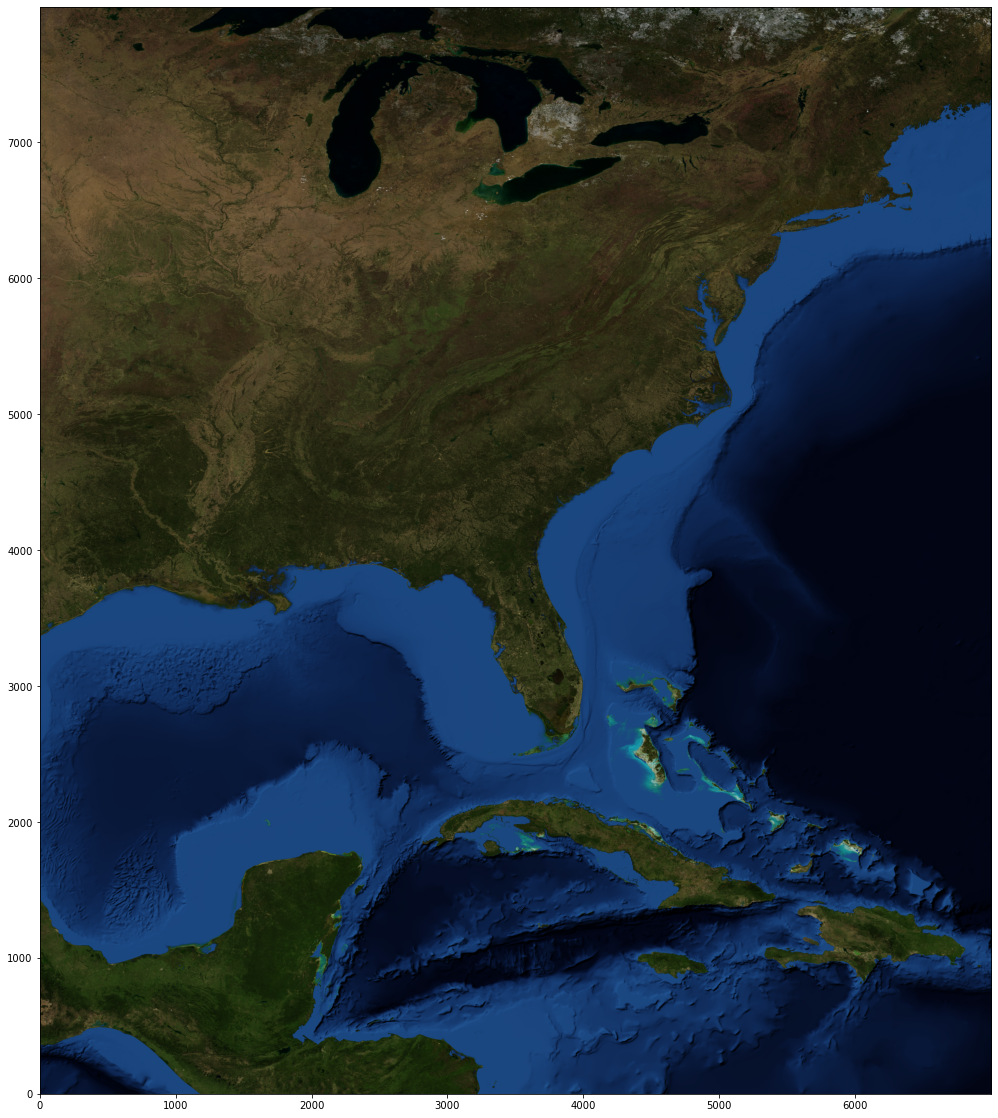

CPU times: user 21 s, sys: 8.44 s, total: 29.4 s
Wall time: 28.9 s


In [6]:
%%time
ds = xr.open_dataset("http://atlantis.sci.utah.edu/mod_visus?dataset=BlueMarble",engine=OpenVisusBackendEntrypoint)

data=ds.data[10,25000:33000,20000:27000].values
ShowData(data[0])



## Using Openvisus only for the same range in datasets as above

In [ ]:
from OpenVisus import *

In [ ]:
%%time
db=LoadDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=BlueMarble")
data=db.read(time=10,logic_box=[(20000,25000),(27000,33000)],max_resolution=21)
ShowData(data)
data.shape

# Example 2 for larger set

In [ ]:
%%time
db=xr.open_dataset('http://atlantis.sci.utah.edu/mod_visus?dataset=david_subsampled', engine=OpenVisusBackendEntrypoint)
data=db.data[3,:10000,:19000].values
ShowData(data[0])

In [ ]:
%%time
db=LoadDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=david_subsampled")
data=db.read(time=3,logic_box=[(0,0),(19000,10000)],max_resolution=32)
ShowData(data)

## Runtime Analysis

| Method   | Dataset | image query | Runtime |
|----------|---------|-------------|---------|
|w Xarray  |Climate  |    8000*7000|   212 ms|
|w/o Xarray|Climate  |    8000*7000|   230 ms|
|w Xarray  |Statue   |  70000*29000|2 m 56 s|
|w/o Xarray|Statue   |  70000*29000|   2 m 58 s|

- Very similar runtime with and without Xarray

- Almost zero overhead after using Xarray

## For 3D datasets using Xarray

### Note that the passed values to access the data are in order of 'time', 'z','y','x','channel','resolution' (channel,resolution is optional)

In [ ]:
# %%time
# db2=xr.open_dataset('http://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1', engine=OpenVisusBackendEntrypoint)
# select_db2=db2.sel(time=0,resolution=31,x=slice(0,2048),y=slice(0,2048),z=slice(1010,1011)).to_array()
# print(select_db2.shape)
# ShowData(select_db2[0][0].values)


In [ ]:
%%time
db2=xr.open_dataset('http://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1', engine=OpenVisusBackendEntrypoint)
print(db2.DATA[0,1010:1011,0:2048,0:2048].shape)
db=db2.DATA[0,1010:1011,0:2048,0:2048,:].values
ShowData(db[0,0,:,:])
db.shape

## For 3D datasets with OpenVisus Alone

In [ ]:
%%time
db=LoadDataset('http://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1')
data= db.read(x=[0,2048],y=[0,2048],z=[1009,1011], num_refinements=1, quality=-1)
print(data.shape)
# ShowData(data[0,:,:])

### Very similar runtime for 3D datasets too

## TODO:
- Extend to S3(remote) datasets
- Work on Normalized coordinates, quality, num_refinements

In [57]:
ds=xr.DataArray("PLANET_SCOPE_3D.nc")

In [58]:
ds

<xarray.DataArray ()>
array('PLANET_SCOPE_3D.nc', dtype='<U18')